# Time Series Forecasting for Aircraft Movements at HKIA

### By Tracy Lee

## 1. Background of the dataset

Hong Kong International Airport (HKIA) is well-known as the busiest cargo gateway and one of the busiest passenger airports in the world. The monthly total movements of aircrafts are a part of the Air Traffic Statistics publicly provided by the Civil Aviation Department of the Hong Kong Government. It counts both the number of landing aircrafts and take-off aircrafts in a month.

In this project, the Box-Jenkins method is applied to build a time series model that explains the total movements of aircrafts at HKIA from January 2009 to May 2019. The sample size of the time series dataset is 125. For the purpose of model evaluation, the data from January 2009 to December 2018 are employed to formulate the time series model, which is then used to forecast the datapoints from January 2019 to May 2019.

Please refer to the website https://www.cad.gov.hk/english/statistics.html for the dataset.

## 2. A first glimpse at the time series dataset

In [ ]:
# import packages
%%R
suppressWarnings(suppressMessages(library(tseries)))
suppressWarnings(suppressMessages(library(forecast)))
suppressWarnings(suppressMessages(library(urca)))
suppressWarnings(suppressMessages(library(portes)))
suppressWarnings(suppressMessages(library(aTSA)))

The monthly total movements of aircrafts at HKIA from January 2009 to May 2019 are shown below:

In [ ]:
%%R
Air_full = ts(read.csv("../data/aircraft-movement.csv", header=TRUE, row.names = 2),
              frequency = 12, start = c(2009, 1), end = c(2019, 5))
print(Air_full)

       Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec
2009 24231 21220 23786 24081 23411 21496 23300 23696 22558 23912 23500 24210
2010 23447 22253 24357 24700 25371 24770 26716 27129 26111 27195 26751 27739
2011 27423 24305 28144 27698 27848 27096 28891 28951 27718 28557 27880 29295
2012 29011 26583 29605 29036 29243 28431 29879 30489 28854 30040 29714 30799
2013 30292 27680 30551 30552 31058 30555 32146 32415 30449 31881 31655 32846
2014 32700 28762 32459 32721 32731 31771 33291 33713 32016 33649 32936 34259
2015 33391 31206 34313 33727 34122 32890 34198 34888 33096 34815 33988 35414
2016 35221 32624 35082 33692 34383 33781 35211 34810 33878 34615 32603 35666
2017 35314 31242 35260 34751 35431 34596 36274 35601 34635 35991 34916 36648
2018 36008 32333 36252 35377 35998 35340 36699 36966 33722 36516 35451 37104
2019 36534 32436 36752 35666 36313                                          


For modelling purpose, the last 5 datapoints are removed. The time plot, sample ACFs and sample PACFs of the above aircraft movement data are shown below:

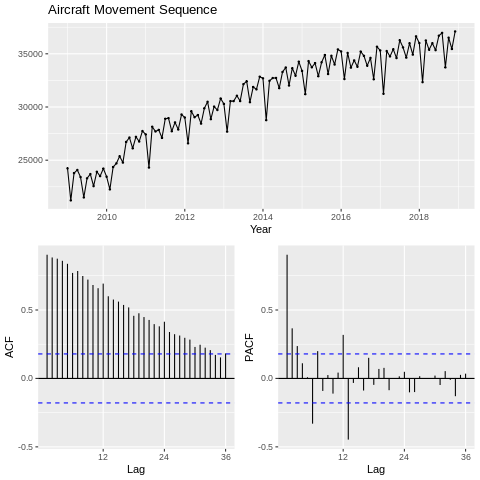

In [ ]:
%%R
Air = subset(Air_full, start = 1, end = 120)
options(repr.plot.width=6, repr.plot.height=4)
ggtsdisplay(Air, main="Aircraft Movement Sequence", xlab="Year")

Observations:

1. From the time plot, there was an increasing trend of aircraft movements during the period, i.e. the mean increased over the years.

2. An increase of dispersion is observed in the time plot as the aircraft movements increased over the period, i.e. the variance increased with the level of the time series.

3. Strong seasonal trend is observed from the time plot. Typically, there were four troughs in a year, the most significant of which occurred in February.

4. The ACFs decay slowly as the number of lags increases. This suggests the non-stationarity of the time series.

Observations 1, 2 and 4 indicate that the time series is not stationary in both mean and variance.

Observation 3 suggests that a seasonal ARIMA model is needed for the time series.

## 3. Transformation of the initial sequence

In view of the above observations, transformation is performed on the initial time series to obtain a stationary sequence for ARMA model building

### 3.1 Log transformation

Due to non-stationarity in variance, a log transformation is performed on the time series as the first step. The time plot, sample ACFs and sample PACFs of the log-transformed sequence are shown below:

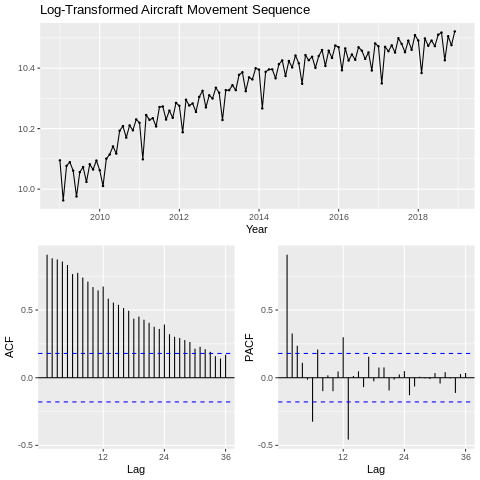

In [ ]:
%%R
LogAir = log(Air)
ggtsdisplay(LogAir, main="Log-Transformed Aircraft Movement Sequence", xlab="Year")

Observations:

1. The increasing trend and the seasonal trend are still present in the time plot. This is expected as a log-transformation aims only at adjusting the variance of the sequence.
2. The dispersion in the time plot is imperceptible now, i.e. the variance is not changing over time.

3. The ACFs still decay slowly as the number of lags increases.

### 3.2 Seasonal differencing

Owing to the seasonality of the log-transformed sequence, a first-order seasonal differencing is performed on the time series yields in the previous step. The time plot, sample ACFs and sample PACFs of the first-order-seasonal-differenced log-transformed sequence are shown below:

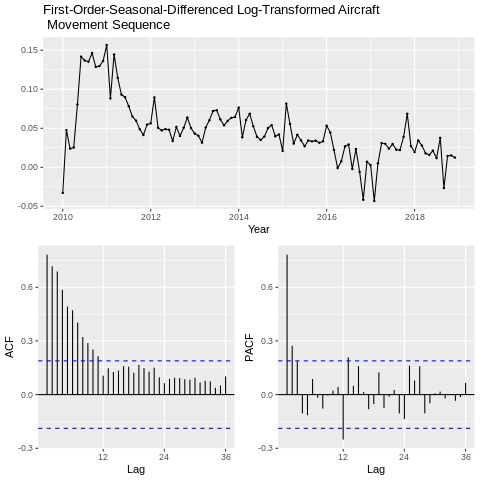

In [ ]:
%%R
SDiffLogAir = diff(LogAir, lag = 12)
ggtsdisplay(SDiffLogAir, 
            main="First-Order-Seasonal-Differenced Log-Transformed Aircraft \n"
            "Movement Sequence", xlab="Year")

Observations:

1. The trend in the time plot has gone. Also, the seasonal trend in the time plot is not obvious.

2. The ACFs decay less slowly but is still significant for the first 6 lags.

To judge whether the first-order-seasonal-differenced log-transformed sequence is stationary, the Augmented Dickey-Fuller unit root tests are conducted. In particular, the *t*-statistic test is employed. Three cases, including zero mean, constant mean and linear trend, are considered. For all cases, the number of lags selected by the AIC. The following table shows the test statistics and the corresponding *p*-values:

In [ ]:
%%R
ur.df(SDiffLogAir, type = "none", selectlags = "AIC")
ur.df(SDiffLogAir, type = "drift", selectlags = "AIC")
ur.df(SDiffLogAir, type = "trend", selectlags = "AIC")
stationary.test(SDiffLogAir, method = "adf", nlag=3)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag   ADF p.value
[1,]   0 -2.09   0.038
[2,]   1 -1.47   0.150
[3,]   2 -1.15   0.267
Type 2: with drift no trend 
     lag   ADF p.value
[1,]   0 -3.69   0.010
[2,]   1 -2.36   0.191
[3,]   2 -1.88   0.374
Type 3: with drift and trend 
     lag   ADF p.value
[1,]   0 -6.16  0.0100
[2,]   1 -4.18  0.0100
[3,]   2 -3.99  0.0129
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


From the *p*-value of the zero-mean/constant-mean case, the null hypothesis that a unit root is present is not rejected at 5% level of significance. Hence, the sequence is non-stationary. However, the *p*-value of the linear-trend case is smaller than 0.05, suggesting that the sequence is trend stationary.

A linear regression model of the sequence is plotted as follows:

Fitted line: Z[t] = 19.5439-0.009678*t

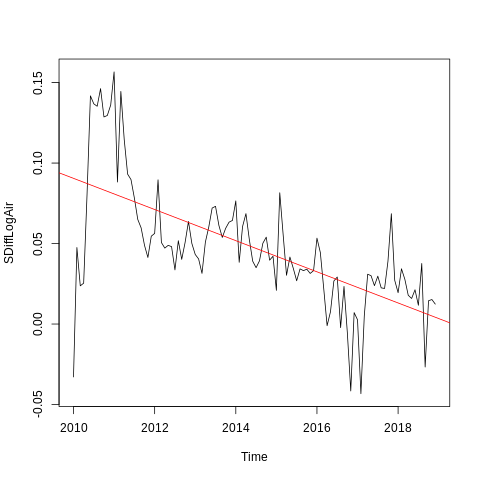

In [ ]:
%%R
fit = lm(as.vector(SDiffLogAir) ~ time(SDiffLogAir))
cat("Fitted line: Z[t] = ", round(fit$coef[1],4), round(fit$coef[2],6), "*t", sep = "")
plot(SDiffLogAir)
abline(fit, col='red')

The Augmented Dickey-Fuller unit root test results lead to two directions, i.e.

(a) to perform further differencing on the sequence to obtain a stationary sequence; and

(b) to build an ARMA model with drift for the sequence to take into account the decreasing trend.

### 3.3 Common differencing

In regard to the evidence which suggests that the first-order-seasonal-differenced log-transformed sequence is not stationary, a first-order common differencing is performed on the sequence as stated in direction (a) in Section 3.2. Note that a common differencing is selected instead of a further seasonal differencing as the seasonal trend in the time plot is not obvious.

The time plot, sample ACFs and sample PACFs of the first-order-common-differenced first-order-seasonal-differenced log-transformed sequence are shown below:

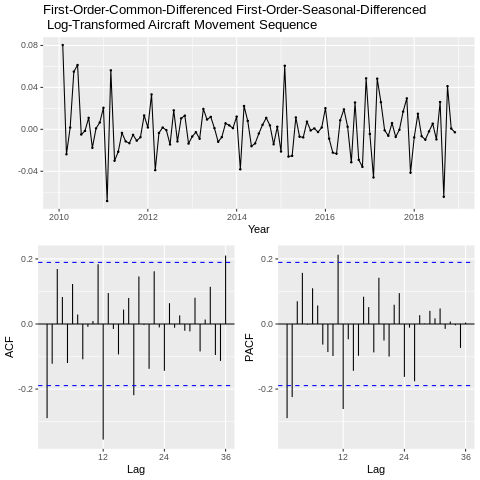

In [ ]:
%%R
CDiffSDiffLogAir = diff(SDiffLogAir)
ggtsdisplay(CDiffSDiffLogAir, 
            main="First-Order-Common-Differenced First-Order-Seasonal-Differenced \n"
            "Log-Transformed Aircraft Movement Sequence", xlab="Year")

Observations:

1. The mean of the time series is approximately zero. No trend is observed.

2. The ACFs decay quickly. They all lie within the accepting region of the Bartlett’s approximation except those at lag 1 and lag 12.

To judge whether the first-order-common-differenced first-order-seasonal-differenced log-transformed sequence is stationary, the Augmented Dickey-Fuller unit root tests are again conducted. The following table shows the test statistics and the corresponding p-values:

In [ ]:
%%R
ur.df(CDiffSDiffLogAir, type = "none", selectlags = "AIC")
ur.df(CDiffSDiffLogAir, type = "drift", selectlags = "AIC")
ur.df(CDiffSDiffLogAir, type = "trend", selectlags = "AIC")
stationary.test(CDiffSDiffLogAir, method = "adf", nlag=3)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag   ADF p.value
[1,]   0 -14.7    0.01
[2,]   1 -10.6    0.01
[3,]   2  -6.8    0.01
Type 2: with drift no trend 
     lag    ADF p.value
[1,]   0 -14.60    0.01
[2,]   1 -10.51    0.01
[3,]   2  -6.77    0.01
Type 3: with drift and trend 
     lag    ADF p.value
[1,]   0 -14.55    0.01
[2,]   1 -10.52    0.01
[3,]   2  -6.77    0.01
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


The p-values of all three cases are less than 0.05, indicating that the sequence is stationary. Thus, an ARMA model would be used to fit this time series in latter sections.

## 4. Model specification

At this point, two sequences are under consideration:

- The first-order-common-differenced first-order-seasonal-differenced log-transformed sequence is stationary.

- The first-order-seasonal-differenced log-transformed sequence is trend stationary.

For each sequence, a model would be specified based on the sample ACFs and PACFs.

### 4.1 Model 1: Seasonal ARIMA model with zero mean

The sample ACFs and sample PACFs of the first-order-common-differenced first-order-seasonal-differenced log-transformed sequence are presented again as follows:

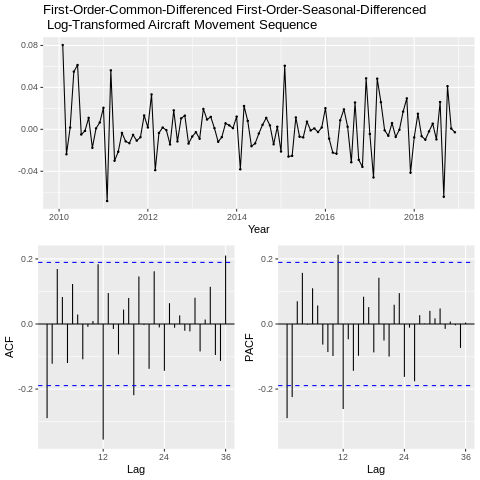

In [ ]:
%%R
ggtsdisplay(CDiffSDiffLogAir, 
            main="First-Order-Common-Differenced First-Order-Seasonal-Differenced \n"
            "Log-Transformed Aircraft Movement Sequence", xlab="Year")

Since the sample ACFs at lag 1 and lag 12 are outside the accepting region of the Bartlett’s approximation, the ACFs at the two lags are significantly different from zero. A multiplicative seasonal ARMA(p,q)(P,Q)$_{12}$ model is thus suitable. The ACF at lag 1 indicates that p = 1, while the ACF at lag 12 indicates that P = 1. Given that the null hypothesis of the zero-mean case of Augmented Dickey-Fuller unit root test is rejected for this sequence in Section 3.3, an ARMA(0,1)(0,1)$_{12}$ model with zero mean is selected for the sequence. This means:

- an ARIMA(0,1,1)(0,0,1)$_{12}$ model with zero mean is selected for the first-order-seasonal-differenced log-transformed aircraft movement sequence; or

- an ARIMA(0,1,1)(0,1,1)$_{12}$ model with zero mean is selected for the log-transformed aircraft movement sequence.

In addition, the possibility of building an MA model is ignored at this point since the PACFs are difficult to explain when a multiplicative seasonal ARMA model is assumed.

### 4.2 Model 2: Seasonal ARIMA model with drift

The detrended first-order-seasonal-differenced log-transformed sequence is obtained by subtracting the first-order-seasonal-differenced log-transformed sequence by the sequence of corresponding values of the fitted linear regression model. To specify the orders of a suitable ARIMA model, the sample ACFs and sample PACFs of the detrended sequence are presented again as follows:

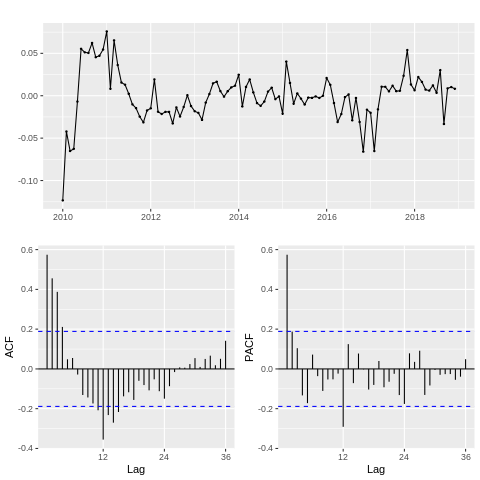

In [ ]:
%%R
DetrendSDiffLogAir = SDiffLogAir - summary(fit)$coefficients[1,1] - time(SDiffLogAir) * summary(fit)$coefficients[2,1]
ggtsdisplay(DetrendSDiffLogAir)

Since the sample ACFs at lag 1, 2, 3 and 12 are apparently outside the accepting region of the Bartlett’s approximation, the ACFs at these lags are significantly different from zero. A multiplicative seasonal ARMA(p,q)(P,Q)$_{12}$ model is then appropriate. The ACFs at lag 1, 2 and 3 indicate that p = 3, while the ACF at lag 12 indicates that P = 1. Hence, an ARMA(0,3)(0,1)$_{12}$ model is selected for the detrended sequence, which implies that an ARIMA(0,0,3)(0,0,1)$_{12}$ model with drift is selected for the first-order-seasonal-differenced log-transformed aircraft movement sequence. Similar to Section 4.1, the PACFs are ignored at this point.

For easy comparison of the AICs of the models obtained in the latter stage, all models will be built for the first-order-seasonal-differenced log-transformed aircraft movement time series.

## 5. Model fitting and diagnostics

Until now, the specified models for the first-order-seasonal-differenced log-transformed aircraft movement sequence are

1. a seasonal ARIMA(0,1,1)(0,0,1)$_{12}$ model with zero mean; and

2. a seasonal ARIMA(0,0,3)(0,0,1)$_{12}$ model with drift.

For each specified model, the parameters would be estimated by the maximum likelihood estimation method. Then, the adequacy of the fitted model would be tested using the Ljung-Box test and overparametrized method. Alternative models would be suggested if the fitted model is not adequate.

### 5.1 Seasonal ARIMA model with zero mean

#### 5.1.1 Parameter estimation

By the maximum likelihood estimation, the parameters of the ARIMA(0,1,1)(0,0,1)$_{12}$ model with zero mean are estimated. The following shows the result:

In [ ]:
%%R
# Function that displays a 95% confidence interval for estimated parameters
CI95.function <- function(model, model_name, param, param_pos, n, df) {
   cat("\n 95% confidence interval of", param, "of", model_name, "= [",
       round(as.numeric(coef(model)[param_pos])
             -qt(1-0.025,n-df)*as.numeric(sqrt(diag(vcov(model)))[param_pos]),4), ",",
       round(as.numeric(coef(model)[param_pos])
             +qt(1-0.025,n-df)*as.numeric(sqrt(diag(vcov(model)))[param_pos]),4), "]")
}

In [ ]:
%%R
m1 = arima(SDiffLogAir, order=c(0,1,1), seasonal=c(0,0,1), method = c("ML"))
print(m1)
m1_param = c("ma1", "sma1")
for (i in 1:2){
    CI95.function(m1, "ARIMA(0,1,1)(0,0,1)[12]", m1_param[i], i, 107, 2)
}


Call:
arima(x = SDiffLogAir, order = c(0, 1, 1), seasonal = c(0, 0, 1), method = c("ML"))

Coefficients:
          ma1     sma1
      -0.3933  -0.7694
s.e.   0.0894   0.0998

sigma^2 estimated as 0.0003199:  log likelihood = 273.28,  aic = -540.56

 95% confidence interval of ma1 of ARIMA(0,1,1)(0,0,1)[12] = [ -0.5705 , -0.2161 ]
 95% confidence interval of sma1 of ARIMA(0,1,1)(0,0,1)[12] = [ -0.9673 , -0.5714 ]

Since both the 95% confidence intervals of $ma1$ and $sma1$ do not include zero, they are significantly different from zero.

The result implies that the first-order-seasonal-differenced log-transformed time series satisfies

$$(1-B)Z_{t}=(1-0.3933B)(1-0.7694B^{12})a_t$$

where $a_{t} \overset{iid}{\sim} WN(0,3.199\times 10^{-4})$.


#### 5.1.2 Ljung-Box test

The Ljung-Box test is conducted on the fitted ARIMA(0,1,1)(0,0,1)$_{12}$ model for different lags. The following shows the test statistics and *p*-values:

In [ ]:
%%R
LjungBox(m1)

 lags statistic df   p-value
    5  6.319547  4 0.1765214
   10  9.140480  9 0.4244091
   15 13.142400 14 0.5153428
   20 15.967517 19 0.6594442
   25 19.866748 24 0.7043282
   30 20.856210 29 0.8643338


Since all the *p*-values above exceed 0.05, there is no evidence to reject the null hypothesis that the error terms have no correlation. Hence, it is concluded that there is no correlation in the errors. The fitted model is adequate.

#### 5.1.3 Overparametrized method

As the ARIMA(0,1,1)(0,0,1)$_{12}$ model with zero mean seems appropriate for the log-transformed time series, some more general models are fitted for comparison below:

In [ ]:
%%R
m2.1 = arima(SDiffLogAir, order=c(1,1,1), seasonal=c(0,0,1), method = c("ML"))
print(m2.1)
m2.2 = arima(SDiffLogAir, order=c(0,1,2), seasonal=c(0,0,1), method = c("ML"))
print(m2.2)
m2.3 = arima(SDiffLogAir, order=c(0,1,1), seasonal=c(1,0,1), method = c("ML"))
print(m2.3)
m2.4 = arima(SDiffLogAir, order=c(0,1,1), seasonal=c(0,0,2), method = c("ML"))
print(m2.4)


Call:
arima(x = SDiffLogAir, order = c(1, 1, 1), seasonal = c(0, 0, 1), method = c("ML"))

Coefficients:
         ar1      ma1     sma1
      0.0883  -0.4586  -0.7741
s.e.  0.1913   0.1600   0.1012

sigma^2 estimated as 0.0003187:  log likelihood = 273.39,  aic = -538.78

Call:
arima(x = SDiffLogAir, order = c(0, 1, 2), seasonal = c(0, 0, 1), method = c("ML"))

Coefficients:
          ma1      ma2     sma1
      -0.3303  -0.0892  -0.7819
s.e.   0.1158   0.1145   0.1037

sigma^2 estimated as 0.0003166:  log likelihood = 273.57,  aic = -539.14

Call:
arima(x = SDiffLogAir, order = c(0, 1, 1), seasonal = c(1, 0, 1), method = c("ML"))

Coefficients:
          ma1     sar1     sma1
      -0.3986  -0.1175  -0.7089
s.e.   0.0899   0.1461   0.1199

sigma^2 estimated as 0.0003188:  log likelihood = 273.59,  aic = -539.17

Call:
arima(x = SDiffLogAir, order = c(0, 1, 1), seasonal = c(0, 0, 2), method = c("ML"))

Coefficients:
          ma1     sma1    sma2
      -0.4046  -0.8881  0.1858
s.e.   

From the above table, it can be observed that the $ma1$ and $sma1$ coefficient estimates do not change significantly from their original estimates (−0.3933 and −0.7694).

Besides, we check the confidence intervals of the additional parameters of the overparametrized models:

In [ ]:
%%R
CI95.function(m2.1, "ARIMA(1,1,1)(0,1,1)[12]", "ar1", 1, 107, 3)
CI95.function(m2.2, "ARIMA(0,1,2)(0,1,1)[12]", "ma2", 2, 107, 3)
CI95.function(m2.3, "ARIMA(0,1,1)(1,1,1)[12]", "sar1", 2, 107, 3)
CI95.function(m2.4, "ARIMA(0,1,1)(0,1,2)[12]", "sma2", 3, 107, 3)


 95% confidence interval of ar1 of ARIMA(1,1,1)(0,1,1)[12] = [ -0.291 , 0.4677 ]
 95% confidence interval of ma2 of ARIMA(0,1,2)(0,1,1)[12] = [ -0.3162 , 0.1379 ]
 95% confidence interval of sar1 of ARIMA(0,1,1)(1,1,1)[12] = [ -0.4072 , 0.1722 ]
 95% confidence interval of sma2 of ARIMA(0,1,1)(0,1,2)[12] = [ -0.1432 , 0.5148 ]

Since every interval contains zero, the estimates of all the additional parameters are not significantly different from zero.

Therefore, the adequacy of the ARIMA(0,1,1)(0,0,1)$_{12}$ model for the first-order-seasonal-differenced log-transformed sequence is confirmed.

### 5.2 Seasonal ARIMA model with drift

#### 5.2.1 Parameter estimation

By the maximum likelihood estimation, the parameters of the ARIMA(0,0,3)(0,0,1)$_{12}$ model for the detrended first-order-seasonal-differenced log-transformed sequence are estimated. The following shows the result:

In [ ]:
%%R
n1 = arima(DetrendSDiffLogAir, order = c(0, 0, 3), seasonal = c(0, 0, 1), method = c("ML"), include.mean=FALSE)
print(n1)
n1_param = c("ma1", "ma2", "ma3", "sma1")
for (i in 1:4){
    CI95.function(n1, "ARIMA(0,0,3)(0,0,1)[12]", n1_param[i], i, 108, 4)
}


Call:
arima(x = DetrendSDiffLogAir, order = c(0, 0, 3), seasonal = c(0, 0, 1), include.mean = FALSE, 
    method = c("ML"))

Coefficients:
         ma1     ma2     ma3     sma1
      0.4836  0.2775  0.3460  -0.8439
s.e.  0.0940  0.0952  0.1052   0.1315

sigma^2 estimated as 0.0002928:  log likelihood = 278.54,  aic = -547.07

 95% confidence interval of ma1 of ARIMA(0,0,3)(0,0,1)[12] = [ 0.2972 , 0.6699 ]
 95% confidence interval of ma2 of ARIMA(0,0,3)(0,0,1)[12] = [ 0.0887 , 0.4662 ]
 95% confidence interval of ma3 of ARIMA(0,0,3)(0,0,1)[12] = [ 0.1374 , 0.5546 ]
 95% confidence interval of sma1 of ARIMA(0,0,3)(0,0,1)[12] = [ -1.1048 , -0.5831 ]

Since the 95% confidence intervals of all the parameters do not include zero, they are significantly different from zero.

The result implies that the first-order-seasonal-differenced log-transformed time series satisfies

$$Z_{t}-19.5439+0.009678t=(1+0.4836B+0.2775B^{2}+0.3460B^{3})(1-0.8439^{12})a_t$$

where $a_{t} \overset{iid}{\sim} WN(0,2.928\times 10^{-4})$.

#### 5.2.2 Ljung-Box test

The Ljung-Box test is conducted on the fitted ARIMA(0,0,3)(0,0,1)$_{12}$ model for different lags. The following shows the test statistics and *p*-values:

In [ ]:
%%R
LjungBox(n1)

 lags statistic df   p-value
    5  3.707108  2 0.1566794
   10  5.276762  7 0.6262287
   15 13.181901 12 0.3559592
   20 15.919417 17 0.5295546
   25 17.182475 22 0.7532109
   30 18.642527 27 0.8826578


Since all the *p*-values are larger than 0.05, there is no correlation in the errors. The model is sufficient to explain the time series. However, note that the *p*-value at lag 5 is close to 0.05, meaning that there may still be some correlation between the errors that differ by a small number of lags.

#### 5.2.3 Overparametrized method

Unlike in Section 5.1.3, the ARIMA(0,0,3)(0,0,1)$_{12}$ model with drift will be revised by applying the overparametrized method a few times.

##### Iteration 1

Some more general models than the ARIMA(0,0,3)(0,0,1)$_{12}$ model for the detrended sequence are fitted for comparison below:

In [ ]:
%%R
n2.1 = arima(DetrendSDiffLogAir, order = c(1, 0, 3), seasonal = c(0, 0, 1), method = c("ML"), include.mean=FALSE)
print(n2.1)
n2.2 = arima(DetrendSDiffLogAir, order = c(0, 0, 4), seasonal = c(0, 0, 1), method = c("ML"), include.mean=FALSE)
print(n2.2)
n2.3 = arima(DetrendSDiffLogAir, order = c(0, 0, 3), seasonal = c(1, 0, 1), method = c("ML"), include.mean=FALSE)
print(n2.3)
n2.4 = arima(DetrendSDiffLogAir, order = c(0, 0, 3), seasonal = c(0, 0, 2), method = c("ML"), include.mean=FALSE)
print(n2.4)


Call:
arima(x = DetrendSDiffLogAir, order = c(1, 0, 3), seasonal = c(0, 0, 1), include.mean = FALSE, 
    method = c("ML"))

Coefficients:
         ar1      ma1      ma2     ma3     sma1
      0.7511  -0.2122  -0.0728  0.2042  -0.8212
s.e.  0.1390   0.1552   0.1136  0.1000   0.1200

sigma^2 estimated as 0.0002773:  log likelihood = 282.08,  aic = -552.16

Call:
arima(x = DetrendSDiffLogAir, order = c(0, 0, 4), seasonal = c(0, 0, 1), include.mean = FALSE, 
    method = c("ML"))

Coefficients:
         ma1     ma2     ma3     ma4     sma1
      0.5614  0.2866  0.3252  0.2691  -0.8368
s.e.  0.0976  0.1124  0.0928  0.1004   0.1284

sigma^2 estimated as 0.0002783:  log likelihood = 281.41,  aic = -550.83

Call:
arima(x = DetrendSDiffLogAir, order = c(0, 0, 3), seasonal = c(1, 0, 1), include.mean = FALSE, 
    method = c("ML"))

Coefficients:
         ma1     ma2     ma3     sar1     sma1
      0.4878  0.2593  0.3253  -0.2119  -0.7329
s.e.  0.0942  0.0962  0.1066   0.1398   0.1207

sigma^2 

From the above table, the ARIMA(1,0,3)(0,0,1)$_{12}$ model with drift gives the smallest AIC (-552.16), which is smaller than the AIC of the ARIMA(0,0,3)(0,0,1)$_{12}$ model (-547.07). Hence, we consider this model instead.

##### Iteration 2

Applying the overparametrized method again on this new model, some more general models than the ARIMA(1,0,3)(0,0,1)$_{12}$ model are fitted for comparison below:

In [ ]:
%%R
n3.1 = arima(DetrendSDiffLogAir, order = c(2, 0, 3), seasonal = c(0, 0, 1), method = c("ML"), include.mean=FALSE)
print(n3.1)
n3.2 = arima(DetrendSDiffLogAir, order = c(1, 0, 4), seasonal = c(0, 0, 1), method = c("ML"), include.mean=FALSE)
print(n3.2)
n3.3 = arima(DetrendSDiffLogAir, order = c(1, 0, 3), seasonal = c(1, 0, 1), method = c("ML"), include.mean=FALSE)
print(n3.3)
n3.4 = arima(DetrendSDiffLogAir, order = c(1, 0, 3), seasonal = c(0, 0, 2), method = c("ML"), include.mean=FALSE)
print(n3.4)


Call:
arima(x = DetrendSDiffLogAir, order = c(2, 0, 3), seasonal = c(0, 0, 1), include.mean = FALSE, 
    method = c("ML"))

Coefficients:
         ar1      ar2      ma1     ma2     ma3     sma1
      1.1602  -0.3693  -0.6066  0.0612  0.2576  -0.8147
s.e.  0.4189   0.3612   0.4042  0.1880  0.1200   0.1170

sigma^2 estimated as 0.0002765:  log likelihood = 282.39,  aic = -550.78

Call:
arima(x = DetrendSDiffLogAir, order = c(1, 0, 4), seasonal = c(0, 0, 1), include.mean = FALSE, 
    method = c("ML"))

Coefficients:
         ar1      ma1      ma2     ma3     ma4     sma1
      0.6237  -0.0593  -0.0295  0.2194  0.1654  -0.8177
s.e.  0.2508   0.2672   0.1406  0.1053  0.1771   0.1189

sigma^2 estimated as 0.0002754:  log likelihood = 282.5,  aic = -551.01

Call:
arima(x = DetrendSDiffLogAir, order = c(1, 0, 3), seasonal = c(1, 0, 1), include.mean = FALSE, 
    method = c("ML"))

Coefficients:
         ar1      ma1      ma2     ma3     sar1     sma1
      0.7536  -0.2184  -0.1017  0.2004  

From the above table, the ARIMA(1,0,3)(0,0,2)$_{12}$ model with drift gives the smallest AIC (-553.74), which is smaller than the AIC of the ARIMA(1,0,3)(0,0,1)$_{12}$ model (-552.16). Hence, we consider this model instead.

##### Iteration 3

Applying the overparametrized method again on this new model, some more general models than the ARIMA(1,0,3)(0,0,2)$_{12}$ model are fitted for comparison below:

In [ ]:
%%R
n4.1 = arima(DetrendSDiffLogAir, order = c(2, 0, 3), seasonal = c(0, 0, 2), method = c("ML"), include.mean=FALSE)
print(n4.1)
n4.2 = arima(DetrendSDiffLogAir, order = c(1, 0, 4), seasonal = c(0, 0, 2), method = c("ML"), include.mean=FALSE)
print(n4.2)
n4.3 = arima(DetrendSDiffLogAir, order = c(1, 0, 3), seasonal = c(1, 0, 2), method = c("ML"), include.mean=FALSE)
print(n4.3)
n4.4 = arima(DetrendSDiffLogAir, order = c(1, 0, 3), seasonal = c(0, 0, 3), method = c("ML"), include.mean=FALSE)
print(n4.4)


Call:
arima(x = DetrendSDiffLogAir, order = c(2, 0, 3), seasonal = c(0, 0, 2), include.mean = FALSE, 
    method = c("ML"))

Coefficients:
         ar1      ar2      ma1     ma2     ma3     sma1    sma2
      1.1125  -0.3304  -0.5792  0.0191  0.2644  -1.0132  0.3002
s.e.  0.4342   0.3973   0.4202  0.2135  0.1306   0.1424  0.1567

sigma^2 estimated as 0.0002667:  log likelihood = 284.07,  aic = -552.15

Call:
arima(x = DetrendSDiffLogAir, order = c(1, 0, 4), seasonal = c(0, 0, 2), include.mean = FALSE, 
    method = c("ML"))

Coefficients:
         ar1      ma1      ma2     ma3     ma4     sma1    sma2
      0.6706  -0.1333  -0.0846  0.2093  0.1073  -1.0106  0.2938
s.e.  0.2270   0.2482   0.1348  0.1033  0.1674   0.1434  0.1586

sigma^2 estimated as 0.0002666:  log likelihood = 284.08,  aic = -552.17

Call:
arima(x = DetrendSDiffLogAir, order = c(1, 0, 3), seasonal = c(1, 0, 2), include.mean = FALSE, 
    method = c("ML"))

Coefficients:
        ar1      ma1      ma2     ma3    sar1   

In addition: Warning messages:
1: In log(s2) : NaNs produced
2: In log(s2) : NaNs produced


From the above table, the ARIMA(1,0,3)(0,0,3)$_{12}$ model with drift gives the smallest AIC (-558.42), which is smaller than the AIC of the ARIMA(1,0,3)(0,0,2)$_{12}$ model (-553.74). Hence, we consider this model instead.

##### Iteration 3

Applying the overparametrized method again on this new model, some more general models than the ARIMA(1,0,3)(0,0,3)$_{12}$ model are fitted for comparison below:

In [ ]:
%%R
n5.1 = arima(DetrendSDiffLogAir, order = c(2, 0, 3), seasonal = c(0, 0, 3), method = c("ML"), include.mean=FALSE)
print(n5.1)
n5.2 = arima(DetrendSDiffLogAir, order = c(1, 0, 4), seasonal = c(0, 0, 3), method = c("ML"), include.mean=FALSE)
print(n5.2)
n5.3 = arima(DetrendSDiffLogAir, order = c(1, 0, 3), seasonal = c(1, 0, 3), method = c("ML"), include.mean=FALSE)
print(n5.3)
n5.4 = arima(DetrendSDiffLogAir, order = c(1, 0, 3), seasonal = c(0, 0, 4), method = c("ML"), include.mean=FALSE)
print(n5.4)


Call:
arima(x = DetrendSDiffLogAir, order = c(2, 0, 3), seasonal = c(0, 0, 3), include.mean = FALSE, 
    method = c("ML"))

Coefficients:
         ar1      ar2      ma1     ma2     ma3     sma1     sma2    sma3
      1.1767  -0.3831  -0.6566  0.1564  0.2188  -1.0397  -0.0427  0.6249
s.e.  0.4871   0.4119   0.4759  0.2137  0.1248   0.3665   0.3171  0.2915

sigma^2 estimated as 0.0001936:  log likelihood = 287.5,  aic = -557

Call:
arima(x = DetrendSDiffLogAir, order = c(1, 0, 4), seasonal = c(0, 0, 3), include.mean = FALSE, 
    method = c("ML"))

Coefficients:
         ar1      ma1     ma2     ma3     ma4     sma1     sma2    sma3
      0.6649  -0.1431  0.0324  0.2158  0.1144  -1.0325  -0.0632  0.6368
s.e.  0.2145   0.2319  0.1323  0.1068  0.1594   0.3792   0.3259  0.3047

sigma^2 estimated as 0.0001933:  log likelihood = 287.47,  aic = -556.95

Call:
arima(x = DetrendSDiffLogAir, order = c(1, 0, 3), seasonal = c(1, 0, 3), include.mean = FALSE, 
    method = c("ML"))

Coefficients:
 

From the above table, it can be observed that all the AICs are larger than that of the ARIMA(1,0,3)(0,0,3)$_{12}$ model (-558.42). Therefore, the overfitting of model terminates here. The validity of the ARIMA(1,0,3)(0,0,3)$_{12}$ model with drift is verified below.

Recall that the result of the ARIMA(1,0,3)(0,0,3)$_{12}$ model:

In [ ]:
%%R
print(n4.4)
n4.4_param = c("ar1", "ma1", "ma2", "ma3", "sma1", "sma2", "sma3")
for (i in 1:7){
    CI95.function(n4.4, "ARIMA(1,0,3)(0,0,3)[12]", n4.4_param[i], i, 108, 7)
}


Call:
arima(x = DetrendSDiffLogAir, order = c(1, 0, 3), seasonal = c(0, 0, 3), include.mean = FALSE, 
    method = c("ML"))

Coefficients:
         ar1      ma1     ma2     ma3     sma1     sma2    sma3
      0.7469  -0.2414  0.0018  0.2081  -1.0449  -0.0325  0.6201
s.e.  0.1349   0.1500  0.1131  0.1031   0.3609   0.3246  0.2869

sigma^2 estimated as 0.0001945:  log likelihood = 287.21,  aic = -558.42

 95% confidence interval of ar1 of ARIMA(1,0,3)(0,0,3)[12] = [ 0.4794 , 1.0145 ]
 95% confidence interval of ma1 of ARIMA(1,0,3)(0,0,3)[12] = [ -0.539 , 0.0562 ]
 95% confidence interval of ma2 of ARIMA(1,0,3)(0,0,3)[12] = [ -0.2226 , 0.2262 ]
 95% confidence interval of ma3 of ARIMA(1,0,3)(0,0,3)[12] = [ 0.0035 , 0.4126 ]
 95% confidence interval of sma1 of ARIMA(1,0,3)(0,0,3)[12] = [ -1.7607 , -0.329 ]
 95% confidence interval of sma2 of ARIMA(1,0,3)(0,0,3)[12] = [ -0.6764 , 0.6115 ]
 95% confidence interval of sma3 of ARIMA(1,0,3)(0,0,3)[12] = [ 0.0509 , 1.1893 ]

Those coefficients whose confidence interval does not include zero are significantly different from zero. Since the confidence intervals of the highest order of ar ($ar1$), ma ($ma3$) and sma ($sma3$) does not include zero, the first-order-seasonal-differenced log-transformed time series satisfies

$(1-0.7469B)(Z_{t}-19.5439+0.009678t)=$
$$(1-0.2414B+0.0018B^{2}+0.2081B^{3})(1-1.0449B^{12}-0.0325B^{24}+0.6201B^{36})a_t$$

where $a_{t} \overset{iid}{\sim} WN(0,1.945\times 10^{-4})$.

Besides, we check the confidence intervals of the additional parameters of the overparametrized models:

In [ ]:
%%R
CI95.function(n5.1, "ARIMA(2,0,3)(0,0,3)[12]", "ar2", 2, 108, 8)
CI95.function(n5.2, "ARIMA(1,0,4)(0,0,3)[12]", "ma4", 5, 108, 8)
CI95.function(n5.3, "ARIMA(1,0,3)(1,0,3)[12]", "sar1", 5, 108, 8)
CI95.function(n5.4, "ARIMA(1,0,3)(0,0,4)[12]", "sma4", 8, 108, 8)


 95% confidence interval of ar2 of ARIMA(2,0,3)(0,0,3)[12] = [ -1.2002 , 0.4341 ]
 95% confidence interval of ma4 of ARIMA(1,0,4)(0,0,3)[12] = [ -0.2019 , 0.4307 ]
 95% confidence interval of sar1 of ARIMA(1,0,3)(1,0,3)[12] = [ -0.8595 , 0.1946 ]
 95% confidence interval of sma4 of ARIMA(1,0,3)(0,0,4)[12] = [ -0.4394 , 0.1559 ]

Since every interval contains zero, the estimates of all the additional parameters are not significantly different from zero.

Therefore, the adequacy of the ARIMA(1,0,3)(0,0,3)$_{12}$ model for the detrended first-order-seasonal-differenced log-transformed sequence is confirmed.

### 5.3 Ultimate model

In Section 5.1 and 5.2, two models have been built for the first-order-seasonal-differenced log-transformed sequence:

**MODEL 1: ARIMA(0,1,1)(0,0,1)$_{12}$ MODEL WITH ZERO MEAN**

$$(1-B)Z_{t}=(1-0.3933B)(1-0.7694B^{12})a_t$$

where $a_{t} \overset{iid}{\sim} WN(0,3.199\times 10^{-4})$.

**MODEL 2: ARIMA(1,0,3)(0,0,3)$_{12}$ MODEL WITH DRIFT**

$(1-0.7469B)(Z_{t}-19.5439+0.009678t)=$
$$(1-0.2414B+0.0018B^{2}+0.2081B^{3})(1-1.0449B^{12}-0.0325B^{24}+0.6201B^{36})a_t$$

where $a_{t} \overset{iid}{\sim} WN(0,1.945\times 10^{-4})$.

The AICs of Model 1 and Model 2 are -547.07 and -558.42 respectively. Since the AIC of Model 2 is smaller, Model 2 is selected as the ultimate model.

The standardized residual sequence resulted from Model 2 is plotted as follows:

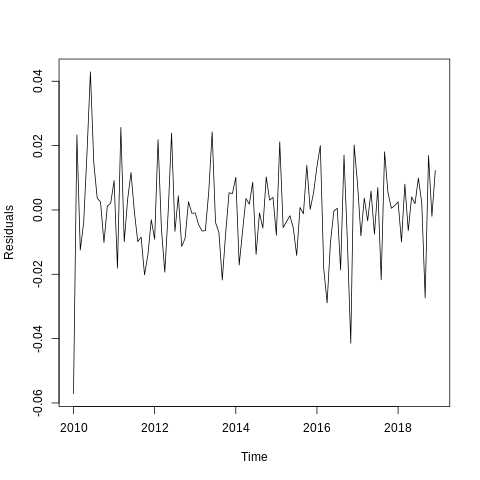

In [ ]:
%%R
plot(residuals(n4.4), ylab="Residuals")

No visible pattern is found from the residual plot.

Then the normality of the residuals is examined below by plotting the histogram and the Q-Q plot:

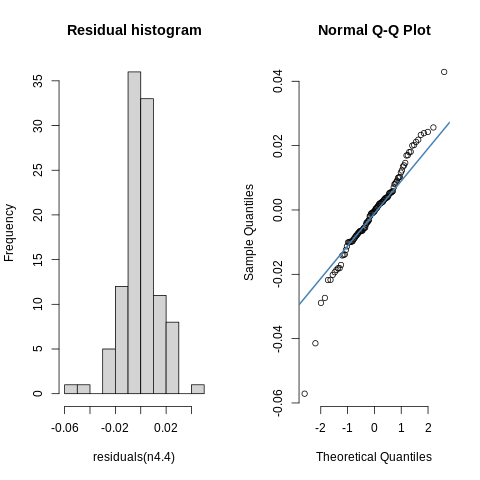

In [ ]:
%%R
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,2))
hist(residuals(n4.4), main="Residual histogram")
qqnorm(residuals(n4.4), pch = 1, frame = FALSE)
qqline(residuals(n4.4), col = "steelblue", lwd = 2)

The plots reveal that the residuals follow a light-tailed distribution instead of a normal distribution.

Moreover, the Shapiro-Wilk normality test is performed to the standardized residual sequence. The following shows the result:

In [ ]:
%%R
shapiro.test(residuals(n4.4))


	Shapiro-Wilk normality test

data:  residuals(n4.4)
W = 0.96336, p-value = 0.004532



Since the *p*-value is smaller than 0.05, the normality is not satisfied.

Despite the above evidence, the normality of the residuals is still assumed in the model. It is believed that the issue arises due to the relatively small sample size.

The sample ACF of the residuals are given as follows:
The

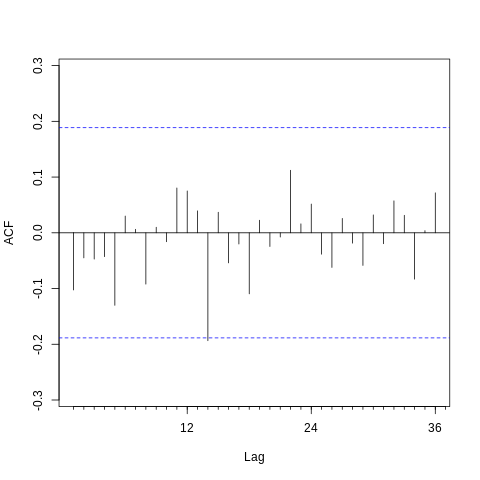

In [ ]:
%%R
options(repr.plot.width=4, repr.plot.height=4)
Acf(residuals(n4.4), lag=36, main="")

The ACFs all lies within the accepting region of the Bartlett’s approximation except at lag 14, which is only a bit out of the boundary. Hence, it is concluded that the error has no correlation.

Last but not least, the adequacy of the fitted model is tested using the Ljung-Box test:

In [ ]:
%%R
LjungBox(n4.4)

 lags statistic df    p-value
    5  3.810950  1 0.05091855
   10  4.971464  6 0.54747824
   15 11.568869 11 0.39690593
   20 13.732357 16 0.61864501
   25 16.103688 21 0.76379723
   30 17.486000 26 0.89366646


Since all the *p*-values above exceed 0.05, there is no evidence to reject the null hypothesis that the error terms have no correlation. Hence, it is concluded that there is no correlation in the errors. The fitted model is adequate.

## 6. Forecasting

Using the fitted ARIMA(1,0,3)(0,0,3)$_{12}$ model, forecasting is performed on the detrended first-order-seasonal-differenced log-transformed sequence values of the next 5 months, i.e. from January 2019 to May 2019. The results, including the forecast values and confidence intervals, are shown in the table and the plot below:

         Point Forecast       Lo 90      Hi 90        Lo 95      Hi 95
Jan 2019    0.011403209 -0.01345787 0.03626429 -0.018220598 0.04102702
Feb 2019    0.030218602  0.00240318 0.05803402 -0.002925517 0.06336272
Mar 2019    0.001379708 -0.02796903 0.03072845 -0.033591472 0.03635089
Apr 2019   -0.002711811 -0.03446476 0.02904114 -0.040547787 0.03512416
May 2019   -0.005641977 -0.03866016 0.02737621 -0.044985568 0.03370161


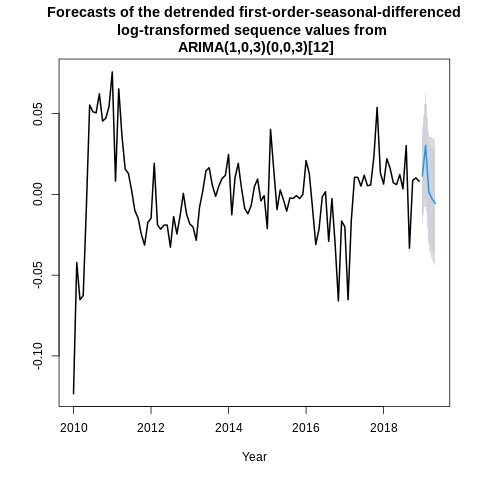

In [ ]:
%%R
options(repr.plot.width=6, repr.plot.height=4)
future = forecast::forecast(n4.4, h=5, level = c(90, 95))
print(future)
plot(future, lwd = 2, main="Forecasts of the detrended first-order-seasonal-differenced
log-transformed sequence values from \n ARIMA(1,0,3)(0,0,3)[12]", xlab="Year")

Adding back the trend, the forecast values are:

In [ ]:
%%R
future$mean = future$mean + summary(fit)$coefficients[1,1] + c(2019, 1/12+2019, 2/12+2019, 3/12+2019, 4/12+2019) * summary(fit)$coefficients[2,1]
print(future$mean)

              Jan          Feb          Mar          Apr          May
2019  0.014792165  0.032801031  0.003155609 -0.001742436 -0.005479129


Performing the inverse seasonal differencing, the forecast values are:

In [ ]:
%%R
future$mean = future$mean + c(LogAir[length(LogAir)-11],LogAir[length(LogAir)-10], LogAir[length(LogAir)-9], LogAir[length(LogAir)-8], LogAir[length(LogAir)-7])
print(future$mean)

          Jan      Feb      Mar      Apr      May
2019 10.50629 10.41664 10.50141 10.47207 10.48574


Performing the inverse log transformation, the forecast values of the initial sequence are:

In [ ]:
%%R
future$mean = exp(future$mean)
print(future$mean)

          Jan      Feb      Mar      Apr      May
2019 36544.60 33411.14 36366.58 35315.41 35801.30


A plot of the actual values and the forecast values from January 2018 to May 2019 is shown below:

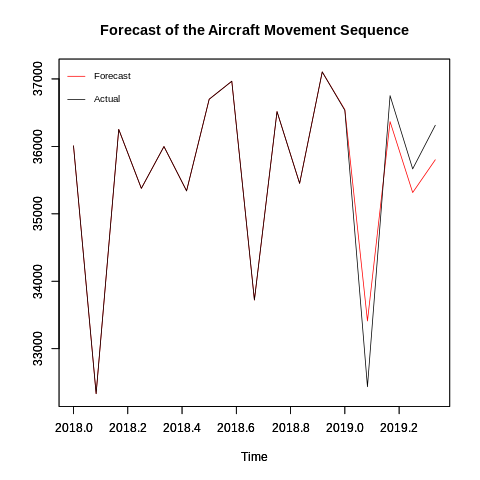

In [ ]:
%%R
options(repr.plot.width=5, repr.plot.height=4)
l = ts(c(subset(Air, start = 109, end = 120),future$mean), frequency=12, start=c(2018, 1), end=c(2019, 5))
plot(l, type='l', col='red', ylab="", main="Forecast of the Aircraft Movement Sequence")
par(new=TRUE)
plot(subset(Air_full, start = 109, end = 125), ylab="")
legend("topleft", legend=c("Forecast", "Actual"), col=c("red", "black"), lty=1, cex=0.8, y.intersp = 2, bty='n')

The prediction errors are computed below:

In [ ]:
%%R
cat('Prediction error (%):\n')
print((future$mean - subset(Air_full, start = 121, end = 125))/subset(Air_full, start = 121, end = 125) * 100)

Prediction error (%):
            Jan        Feb        Mar        Apr        May
2019  0.0290009  3.0063545 -1.0487107 -0.9829768 -1.4091326


## 7. Insights about the time series

Recall the ultimate ARIMA(1,0,3)(0,0,3)$_{12}$ model with drift, which describes the first-order-seasonal-differenced log-transformed aircraft movement time series:

$(1-0.7469B)(Z_{t}-19.5439+0.009678t)=$
$$(1-0.2414B+0.0018B^{2}+0.2081B^{3})(1-1.0449B^{12}-0.0325B^{24}+0.6201B^{36})a_t$$

where $a_{t} \overset{iid}{\sim} WN(0,1.945\times 10^{-4})$.

First, the first-order-seasonal-differenced log-transformed sequence has been decreasing over the period as revealed by the drift coefficient, or the coefficient of $t$. Since the fitted regression line (in Section 3.2) is always above the x-axis, this means the log-transformed sequence has been increasing in a decreasing rate over the years, i.e. the growth of the aircraft movement has slowed down.

Second, the AR(1) part reveals the momentum effect of aircraft movements, since in the model, Z$_{t}$ is positively correlated to Z$_{t-1}$, meaning that a high record of movement will be most likely followed by a high one, and vice versa.

Lastly, the MA(3) and SMA(3) parts indicates that the shock effects observed in the last 3 months and the same month in the last 3 years can affect the aircraft movement value of the current month. Alternatively, this suggests a shock effect can last for 3 months and the impact continues in the coming 3 years.